<a href="https://colab.research.google.com/github/Aayush360/Fast_AI/blob/master/Regression_Ch_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Regression (Biwi Kinect Head pose Dataset)

In [1]:
# we''ll be doing a key-point model; Key-point refers to specific location present in an image

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

### Assembling the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/13'),Path('/root/.fastai/data/biwi_head_pose/03'),Path('/root/.fastai/data/biwi_head_pose/09'),Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/05'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/12.obj'),Path('/root/.fastai/data/biwi_head_pose/23'),Path('/root/.fastai/data/biwi_head_pose/04.obj')...]

In [4]:
# we have 24 directories (1-24) for different people, each directory contains one .obj file in it

In [5]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00467_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00475_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00454_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00465_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00057_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00072_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00144_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00245_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00223_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00088_rgb.jpg')...]

In [6]:
# get all image file and convert all image file into its associated pose file

In [7]:
image_files = get_image_files(path)
image_files

(#15678) [Path('/root/.fastai/data/biwi_head_pose/13/frame_00467_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00057_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00144_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00245_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00223_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00088_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00459_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00399_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00082_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00466_rgb.jpg')...]

In [8]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(image_files[0])

Path('/root/.fastai/data/biwi_head_pose/13/frame_00467_pose.txt')

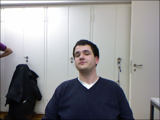

In [9]:
# let's look at our first image

im = PILImage.create(image_files[0])
im.shape
im.to_thumb(160)

In [10]:
# function to extract the head centr point

In [14]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0]* cal[0][0]/ctr[2]+cal[0][2]
  c2 = ctr[1] *cal[1][1]/ctr[2] +cal[1][2]
  return tensor([c1,c2])

In [15]:
# returns coordinates as tensors of 2 items 

get_ctr(image_files[0])

tensor([342.6052, 228.2558])

In [16]:
# preparing the datablock

biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms = [*aug_transforms(size=(240,320)),
                  Normalize.from_stats(*imagenet_stats)]

)

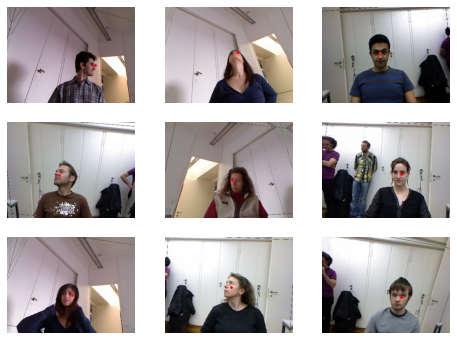

In [17]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n = 9, figsize=(8,6))

In [19]:
# look at the underlying tensors to see what our model is really seeing
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [22]:
# one row from the dependent variable
yb[0], yb[0].shape

(tensor([[-0.1281,  0.2884]], device='cuda:0'), torch.Size([1, 2]))

In [26]:
# Interpretation of shape:  we have 64 images in each batch and each image's label is of size (1,2)
# similarly, for our independent variable(image), we have each image of size 3,240,320 - 3 is the number of channels, 240x320 is the height and 
# width after transformation and we have 64 image batches


### Training a model

In [27]:
# coordinates in pytorch is rescaled between -1 and 1, thus we use y_range in our learner
# this is implemented using application of sigmoid function

In [35]:
# implementatino of y-range

def sigmoid_range(x,lo,hi): return torch.sigmoid(x)*(hi-lo)+ lo

# this is set as the final layer of the model, if y_range is defined

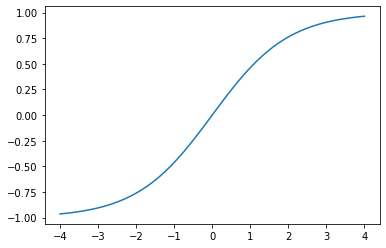

In [31]:
plot_function(partial(sigmoid_range, lo=-1, hi=1),min=-4, max=4)

In [33]:
# create a learner

learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [38]:
# since we didn't specify the loss function, let's see what it has chosen for us

dls.loss_func

FlattenedLoss of MSELoss()

In [39]:
# since the dependent variable is in the form of coordinates, it makes sense to choose mean squared_error as the loss funciton which we want to minimize
# also for accuracy, MSE could be useful (interpretable by humans), less the distance from the targeted point, better is the accuracy (RMSE is even better)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.02754228748381138)

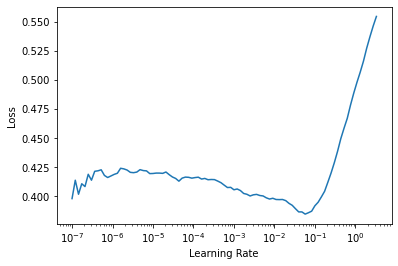

In [41]:
# find the good learning rate using LR_FINDER

learn.lr_find()

In [42]:
# last point where loss was clearly decreasing

lr = 2e-2
learn.fit_one_cycle(5,lr)

epoch,train_loss,valid_loss,time
0,0.042875,0.004777,01:48
1,0.006648,0.001896,01:48
2,0.003029,0.001256,01:48
3,0.002182,0.000166,01:49
4,0.001622,0.000226,01:49


In [43]:
math.sqrt(0.0002)

0.01414213562373095

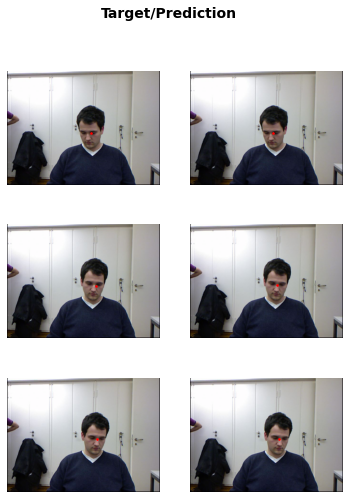

In [48]:
learn.show_results(ds_idx=1,max_n=12, figsize=(6,8))